In [1]:
# Data Preprocessing
import pandas as pd
from pandas_datareader.data import DataReader
from ta.volume import VolumeWeightedAveragePrice

# Environment
import gym
from gym import spaces
import numpy as np
import random
import torch

# PyTorch
import os
import numpy as np
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

# Outputs
import matplotlib.pyplot as plt

### Data Preprocessing

In [2]:
# Data Extraction
start_date = "2017-01-1"
end_date = "2022-06-01"
symbol = "AAPL"
df = DataReader(name=symbol, data_source='yahoo', start=start_date, end=end_date)
df.drop(columns=["Adj Close"], inplace=True)
df.head(2)

,High,Low,Open,Close,Volume
Date,,,,,
2017-01-03,29.082500,28.690001,28.950001,29.037500,115127600.0
2017-01-04,29.127501,28.937500,28.962500,29.004999,84472400.0


In [3]:
# Add VWAP to DataFrame
vwap = VolumeWeightedAveragePrice(high=df["High"], low=df["Low"], close=df["Close"], 
                                  volume=df["Volume"], window=14, fillna=False)
df["VWAP"] = vwap.volume_weighted_average_price()
df.dropna(inplace=True)
df.head(2)

,High,Low,Open,Close,Volume,VWAP
Date,,,,,,
2017-01-23,30.202499,29.942499,30.000000,30.0200,88200800.0,29.663470
2017-01-24,30.025000,29.875000,29.887501,29.9925,92844000.0,29.737769


In [4]:
# Min Max Scaled
df_mod = df.copy()
df_mod = df_mod.pct_change() * 100
df_mod = df_mod / df_mod.max()
df_mod = df_mod.dropna()
df_mod = df_mod.reset_index(drop=True)
df_mod["Close_Price"] = df["Close"].iloc[1:].values
df_mod.head()

,High,Low,Open,Close,Volume,VWAP,Close_Price
0,-0.055937,-0.022097,-0.038558,-0.007646,0.020029,0.132253,29.992500
1,0.158500,0.063981,0.074826,0.132884,0.150258,0.161017,30.469999
2,0.026504,0.107573,0.106732,0.004109,-0.070977,0.152441,30.485001
3,-0.006996,0.000000,0.039719,0.000684,-0.083421,0.134313,30.487499
4,-0.056011,-0.075773,-0.101862,-0.021902,0.181599,0.093867,30.407499


In [5]:
# Split Training and Testing
df_train = df_mod.copy()
df_train = df_train.iloc[:700]
df_test = df_mod.copy()
df_test = df_test.iloc[700:]

<AxesSubplot:>

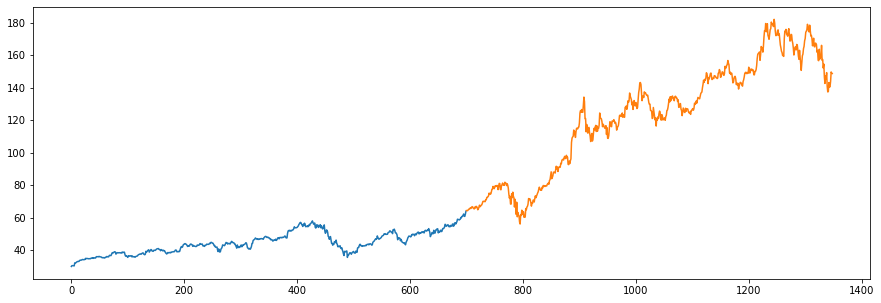

In [6]:
# View price behaviour
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,5)
df_train["Close_Price"].plot()
df_test["Close_Price"].plot()

### Environment

In [7]:
# Initialise variables
MAX_INT = 2147483647
MAX_TRADES = 10000
MAX_OPEN_POSITIONS = 1
INITIAL_ACCOUNT_BALANCE = 1000
PERCENT_CAPITAL = 0.1
TRADING_COSTS_RATE = 0.001
KILL_THRESH = 0.4 # Threshold for balance preservation


# Structure environment
class StockTradingEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df):
        super(StockTradingEnv, self).__init__()
        
        # Generic variables
        self.df = df
        
        # Account variables
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        
        # Position variables
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.long_short_ratio = 0
        
        # Current Step
        self.current_step = 0
        self.lag = 20
        self.volatility = 1
        self.max_steps = len(df)

        # Actions of the format Long, Hold, Close
        self.action_space = spaces.Discrete(2)

        # Prices contains the Close and Close Returns etc
        self.observation_space = spaces.Box(low=-1, high=1, shape=(7, ), dtype=np.float32)

    # Calculate Reward
    def _calculate_reward(self):
        reward = 0
        reward += self.net_profit / self.volatility
        reward += 0.01 if self.long_short_ratio >= 0.3 and self.long_short_ratio <= 0.6 else -0.01
        return reward
        
    # Structure sign observation data
    def _next_observation(self):
        
        item_0_T0 = self.df.loc[self.current_step - 0, "Open"].item()
        item_1_T0 = self.df.loc[self.current_step - 0, "High"].item()       
        item_2_T0 = self.df.loc[self.current_step - 0, "Low"].item()
        item_3_T0 = self.df.loc[self.current_step - 0, "Close"].item()
        item_4_T0 = self.df.loc[self.current_step - 0, "Volume"].item()
        item_5_T0 = self.df.loc[self.current_step - 0, "VWAP"].item()
        
        env_4 = 1 if self.long_short_ratio else 0
        
        obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, env_4])
        
        return obs

    # Set the current price to a random price within the time step
    def _take_action(self, action):
        current_price = self.df.loc[self.current_step, "Close_Price"].item()
        next_price = self.df.loc[self.current_step + 1, "Close_Price"].item()
        next_return = next_price / current_price - 1
        
        # Go Long
        if action == 0:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * next_return
            self.available_balance += self.net_profit
            self.num_trades_long += 1
                
        # Go Short
        if action == 1:
            self.net_profit += self.available_balance * PERCENT_CAPITAL * -next_return
            self.available_balance += self.net_profit
            self.num_trades_short += 1
        
        # Update metrics
        self.long_short_ratio = self.num_trades_long / (self.num_trades_long + self.num_trades_short)
        self.volatility = self.df.loc[self.current_step - self.lag, "Close_Price"].sum()

    # Execute one time step within the environment
    def step(self, action):
        self._take_action(action)

        reward = self._calculate_reward()
    
        self.current_step += 1
        
        is_max_steps_taken = self.current_step >= self.max_steps - self.lag - 1
        done = True if is_max_steps_taken else False
        
        obs = self._next_observation()

        return obs, reward, done, {}

    # Reset the state of the environment to an initial state
    def reset(self):
        self.available_balance = INITIAL_ACCOUNT_BALANCE
        self.net_profit = 0
        self.current_step = self.lag
        self.num_trades_long = 0
        self.num_trades_short = 0
        self.num_trades_ratio = 0

        return self._next_observation()

    # Render the environment to the screen
    def render(self, mode='human', close=False):
        pass

In [8]:
# Test Environment
env = StockTradingEnv(df_train)
actions = [0,1,2]
observation = env.reset()
print("Initial Observation: ", env.reset())

for action in actions:
    obs_, reward, done, info = env.step(action)
    print("")
    print("Action Taken: ", action)
    print("Reward Received : ", reward)
    print("Next State: ", obs_)
    print("Completed: ", done)
    print("-------------------")
    print("Available Balance: ", env.available_balance)
    print("Realized Profit: ", env.net_profit)
    print("Ratio: ", env.num_trades_ratio)
    print("-------------------")

Initial Observation:  [ 0.01509509  0.02575197  0.00937149  0.02503413 -0.0569813   0.46506052
  0.        ]

Action Taken:  0
Reward Received :  -0.02410417084302246
Next State:  [ 7.15985945e-02  2.49887330e-02  1.36833751e-02 -3.53080268e-02
 -8.89242817e-04  2.47030709e-01  1.00000000e+00]
Completed:  False
-------------------
Available Balance:  999.5769806516864
Realized Profit:  -0.42301934831360244
Ratio:  0
-------------------

Action Taken:  1
Reward Received :  -0.007006886294020834
Next State:  [-0.11002195 -0.05676909 -0.07335508  0.00794776  0.01809007  0.19031721
  1.        ]
Completed:  False
-------------------
Available Balance:  999.0587808379853
Realized Profit:  -0.5181998137011128
Ratio:  0
-------------------

Action Taken:  2
Reward Received :  -0.006998517412696118
Next State:  [ 0.09305449  0.05432432  0.07245869  0.01648989 -0.02654296  0.18722969
  1.        ]
Completed:  False
-------------------
Available Balance:  999.0587808379853
Realized Profit:  -0.5

In [9]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []
        self.dones = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                np.array(self.dones),\
                batches

    def store_memory(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [10]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo') #Original V1 has some awesome weights
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [11]:
class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.AdamW(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [12]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward, done):
        self.memory.store_memory(state, action, probs, vals, reward, done)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)
        state = state.flatten(0)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, dones_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            
            # Calculate the advantage
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()

In [13]:
# Testing

env = StockTradingEnv(df_train)

batch_size = 5
n_epochs = 4
alpha = 0.0003

agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                alpha=alpha, n_epochs=n_epochs, 
                input_dims=env.observation_space.shape)

observation = env.reset()
action, prob, val = agent.choose_action(observation)
n_actions = env.action_space.n
print("Oberservation: ", observation)
print("Number of Actions: ", n_actions)
print("Action Chosen: ", action)
print("Probability of Action: ", prob)
print("Value of Action: ", val)

observation_, reward, done, info = env.step(action)
print("Next Oberservation", observation_)
print("Reward", reward)
print("Done", done)
print("Info", info)

Oberservation:  [ 0.01509509  0.02575197  0.00937149  0.02503413 -0.0569813   0.46506052
  0.        ]
Number of Actions:  2
Action Chosen:  1
Probability of Action:  -0.6871256232261658
Value of Action:  -0.03795049712061882
Next Oberservation [ 0.07159859  0.02498873  0.01368338 -0.03530803 -0.00088924  0.24703071
  0.        ]
Reward 0.004104170843022458
Done False
Info {}


/var/folders/3j/87wdpy513z54s00d78h1l8mw0000gn/T/ipykernel_5929/1842526210.py:27: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /private/var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_croot-4qf3nw4h/pytorch_1648016051178/work/torch/csrc/utils/tensor_new.cpp:201.)
  state = T.tensor([observation], dtype=T.float).to(self.actor.device)


... starting ...
... saving models ...
episide: 0, score: 148.5101060104729, avg score: 148.5101060104729, best_score: 148.5101060104729
episide: 1, score: -76.80059406773938, avg score: 35.85475597136676, best_score: 148.5101060104729
episide: 2, score: -125.69508520319994, avg score: -17.995191086822143, best_score: 148.5101060104729
episide: 3, score: -541.3829121269937, avg score: -148.84212134686504, best_score: 148.5101060104729
episide: 4, score: -144.0423968502244, avg score: -147.8821764475369, best_score: 148.5101060104729
episide: 5, score: -23.27793138152671, avg score: -127.11480226986855, best_score: 148.5101060104729
episide: 6, score: -53.25184467322225, avg score: -116.56295118463335, best_score: 148.5101060104729
episide: 7, score: -30.443681640282705, avg score: -105.79804249158953, best_score: 148.5101060104729
episide: 8, score: -52.71338691571601, avg score: -99.89974742760359, best_score: 148.5101060104729
episide: 9, score: -52.25833323036232, avg score: -95.135

episide: 81, score: -54.68103675310081, avg score: -94.56394180561983, best_score: 148.5101060104729
episide: 82, score: -55.68425120914248, avg score: -94.61027031060465, best_score: 148.5101060104729
episide: 83, score: -47.53690654179758, avg score: -94.50498523608263, best_score: 148.5101060104729
episide: 84, score: -51.03849978447381, avg score: -94.46277846728293, best_score: 148.5101060104729
episide: 85, score: -53.98918583330719, avg score: -94.51518146551703, best_score: 148.5101060104729
episide: 86, score: -53.14883822445817, avg score: -94.51518146551703, best_score: 148.5101060104729
episide: 87, score: -55.24880575823746, avg score: -94.5381886615352, best_score: 148.5101060104729
episide: 88, score: -53.13870057468045, avg score: -92.33355711680836, best_score: 148.5101060104729
episide: 89, score: -48.13211102044924, avg score: -25.728272161295937, best_score: 148.5101060104729
episide: 90, score: -55.885882579598295, avg score: -26.392183116416795, best_score: 148.51

episide: 162, score: -6.526341282504157, avg score: -179.21922286488487, best_score: 148.5101060104729
episide: 163, score: 33.85030943542872, avg score: -177.47923991168716, best_score: 148.5101060104729
episide: 164, score: -19.530707914276135, avg score: -176.8068773054835, best_score: 148.5101060104729
episide: 165, score: 70.04122206361335, avg score: -174.34307609972208, best_score: 148.5101060104729
episide: 166, score: 50.151100960766236, avg score: -172.2770773160176, best_score: 148.5101060104729
episide: 167, score: -2.220087134974856, avg score: -171.25850229422792, best_score: 148.5101060104729
episide: 168, score: -31.794123798476342, avg score: -170.83140800570825, best_score: 148.5101060104729
episide: 169, score: 4.937812847699441, avg score: -169.6696749842651, best_score: 148.5101060104729
episide: 170, score: -36.850821094182066, avg score: -169.34371464165957, best_score: 148.5101060104729
episide: 171, score: -31.815892916107998, avg score: -168.9344422320424, bes

episide: 243, score: 81.48975085199228, avg score: 107.75403121652606, best_score: 148.5101060104729
episide: 244, score: -10.634521576602317, avg score: 108.57351637337834, best_score: 148.5101060104729
episide: 245, score: -101.42513882618148, avg score: 107.13975839804404, best_score: 148.5101060104729
episide: 246, score: -66.16840534544014, avg score: 106.83754246248569, best_score: 148.5101060104729
episide: 247, score: -69.17260165304228, avg score: 106.36014001114577, best_score: 148.5101060104729
episide: 248, score: -272.75243931264544, avg score: 102.53580413151825, best_score: 148.5101060104729
episide: 249, score: -263.8382051324084, avg score: 98.23222890077892, best_score: 148.5101060104729
episide: 250, score: 405.97453155815646, avg score: 107.4597316881164, best_score: 148.5101060104729
episide: 251, score: 601.757192682377, avg score: 120.42324198263242, best_score: 148.5101060104729
episide: 252, score: -112.03548131757947, avg score: 119.17784018883667, best_score:

episide: 323, score: -53.52531566699048, avg score: -50.2434645177931, best_score: 170.34440655073362
episide: 324, score: -53.52531566699048, avg score: -50.243392473606, best_score: 170.34440655073362
episide: 325, score: -53.52531566699048, avg score: -49.09439776623522, best_score: 170.34440655073362
episide: 326, score: -53.52531566699048, avg score: -49.79283966833808, best_score: 170.34440655073362
episide: 327, score: -53.52531566699048, avg score: -49.94688186343288, best_score: 170.34440655073362
episide: 328, score: -53.52531566699048, avg score: -49.68924887340867, best_score: 170.34440655073362
episide: 329, score: -53.52531566699048, avg score: -49.81794785524469, best_score: 170.34440655073362
episide: 330, score: -53.52531566699048, avg score: -50.102212036771746, best_score: 170.34440655073362
episide: 331, score: -53.52531566699048, avg score: -50.09894071052632, best_score: 170.34440655073362
episide: 332, score: -53.52531566699048, avg score: -50.15108418056197, bes

episide: 403, score: -46.27924917708177, avg score: -48.42048749226433, best_score: 170.34440655073362
episide: 404, score: -30.053647951525367, avg score: -47.951054137955026, best_score: 170.34440655073362
episide: 405, score: -18.477944428604726, avg score: -47.25010671318731, best_score: 170.34440655073362
episide: 406, score: -28.686203016421555, avg score: -46.753324460175925, best_score: 170.34440655073362
episide: 407, score: -16.76620523951688, avg score: -46.01814225162645, best_score: 170.34440655073362
episide: 408, score: -11.251935138826674, avg score: -45.172674641063175, best_score: 170.34440655073362
episide: 409, score: -211.4314565187983, avg score: -48.33079745809935, best_score: 170.34440655073362
episide: 410, score: -6555.80677301021, avg score: -178.37642660496374, best_score: 170.34440655073362
episide: 411, score: 3530.766099706474, avg score: -106.69059829749443, best_score: 170.34440655073362
episide: 412, score: 1520.5817694061577, avg score: -75.2084565960

episide: 482, score: 1595.8998825659949, avg score: -3045.156231048777, best_score: 351.76255259282436
episide: 483, score: 62.1491921506215, avg score: -2943.679344288745, best_score: 351.76255259282436
episide: 484, score: 3496.062035615505, avg score: -2791.0128966841603, best_score: 351.76255259282436
episide: 485, score: -161.89138526952496, avg score: -2761.784762551364, best_score: 351.76255259282436
episide: 486, score: 28.489185116657563, avg score: -2805.6039950708578, best_score: 351.76255259282436
episide: 487, score: -252.68274322180372, avg score: -2735.392957632486, best_score: 351.76255259282436
episide: 488, score: -148.44503477327171, avg score: -2607.1885848284164, best_score: 351.76255259282436
episide: 489, score: -82.25128805349902, avg score: -2572.799806216121, best_score: 351.76255259282436
episide: 490, score: -116.44012934508703, avg score: -2522.5567021191127, best_score: 351.76255259282436
episide: 491, score: 12.471637842620192, avg score: -2418.2400388025

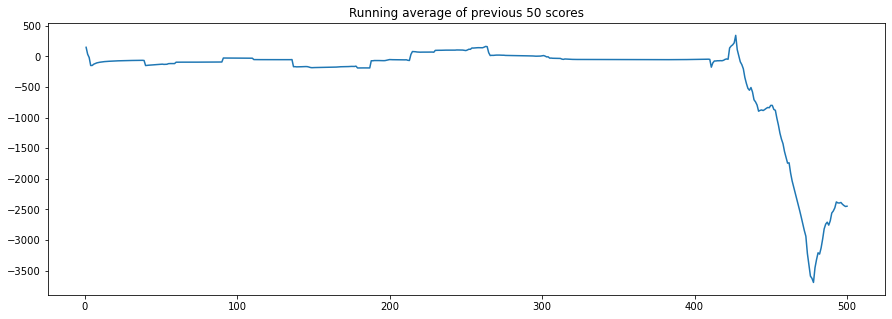

In [14]:
def plot_learning_curve(x, scores, figure_file):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-50):(i+1)])
    plt.plot(x, running_avg)
    plt.title('Running average of previous 50 scores')
    plt.savefig(figure_file)

if __name__ == '__main__':
    env = StockTradingEnv(df_train)
    N = 20
    batch_size = 5
    n_epochs = 3
    alpha = 0.0003
    agent = Agent(n_actions=env.action_space.n, batch_size=batch_size, 
                    alpha=alpha, n_epochs=n_epochs, 
                    input_dims=env.observation_space.shape)

    n_games = 500

    figure_file = 'stock_training.png'

    best_score = env.reward_range[0]
    score_history = []

    learn_iters = 0
    avg_score = 0
    n_steps = 0
    
    print("... starting ...")
    for i in range(n_games):
        observation = env.reset()
        done = False
        score = 0
        while not done:
            action, prob, val = agent.choose_action(observation)
            observation_, reward, done, info = env.step(action)
            n_steps += 1
            score += reward
            agent.remember(observation, action, prob, val, reward, done)
            if n_steps % N == 0:
                agent.learn()
            observation = observation_
            
        # Save history
        score_history.append(score)
        avg_score = np.mean(score_history[-50:])
        
        if avg_score > best_score:
            best_score = avg_score
            agent.save_models()
        
        print(f"episide: {i}, score: {score}, avg score: {avg_score}, best_score: {best_score}")
            
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history, figure_file)

### Load Model

In [15]:
# agent.save_models()
n_actions = env.action_space.n
input_dims = env.observation_space.shape
alpha = 0.0003
model = ActorNetwork(n_actions, input_dims, alpha)
model.load_state_dict(T.load("tmp/actor_torch_ppo"))
model.eval()

ActorNetwork(
  (actor): Sequential(
    (0): Linear(in_features=7, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=2, bias=True)
    (5): Softmax(dim=-1)
  )
)

In [16]:
reporting_df = df_test.copy()
long_probs = []
short_probs = []
is_long = 1
is_short = 1
long_ratio = 0.5
for step in range(5, len(reporting_df)):

    item_0_T0 = df_mod.loc[step - 0, "Open"].item()
    item_1_T0 = df_mod.loc[step - 0, "High"].item()
    item_2_T0 = df_mod.loc[step - 0, "Low"].item()
    item_3_T0 = df_mod.loc[step - 0, "Close"].item()
    item_4_T0 = df_mod.loc[step - 0, "Volume"].item()
    item_5_T0 = df_mod.loc[step - 0, "VWAP"].item()
    
    obs = np.array([item_0_T0, item_1_T0, item_2_T0, item_3_T0, item_4_T0, item_5_T0, long_ratio])
    
    state = T.tensor(obs).float()
    dist = model(state)
    probs = dist.probs.detach().numpy()
    
    print(np.argmax(probs), probs)
    
    if action == 0:
        is_long += 1
    if action == 0:
        is_short += 1
    long_ratio = is_long / (is_long + is_short)

    long_probs.append(probs[0])
    short_probs.append(probs[1])

0 [9.9999988e-01 1.6379565e-07]
0 [1.0000000e+00 3.2994073e-26]
0 [1.0000000e+00 4.0790726e-09]
0 [1.000000e+00 8.701582e-09]
0 [1.0000000e+00 2.5350191e-10]
0 [1.0000000e+00 2.1479074e-11]
0 [1.0000000e+00 1.3313597e-09]
0 [1.00000000e+00 1.02234035e-08]
0 [1.0000000e+00 1.9516546e-09]
0 [1.0000000e+00 7.1835715e-10]
0 [1.0000000e+00 3.2010947e-10]
0 [1.0000000e+00 2.4739386e-11]
0 [1.0000000e+00 2.5914678e-08]
0 [1.0000000e+00 2.6013229e-08]
0 [1.0000000e+00 4.3177083e-11]
0 [1.000000e+00 2.021565e-09]
0 [1.000000e+00 6.927615e-09]
0 [9.9999642e-01 3.5738913e-06]
0 [1.0000000e+00 7.5677653e-10]
0 [1.0000000e+00 2.8157602e-08]
0 [1.0000000e+00 2.7712452e-11]
0 [1.0000000e+00 5.2666616e-10]
0 [9.9999976e-01 2.8219790e-07]
0 [1.0000000e+00 3.9873886e-08]
0 [1.000000e+00 4.411154e-08]
0 [9.999999e-01 1.527499e-07]
0 [9.9999440e-01 5.6198282e-06]
0 [1.0000000e+00 1.9240447e-09]
0 [9.9999988e-01 1.0351082e-07]
0 [1.0000000e+00 4.3503178e-08]
0 [1.000000e+00 8.488895e-09]
0 [1.0000000e+00 1

0 [9.9997872e-01 2.1295931e-05]
0 [9.9995816e-01 4.1818199e-05]
0 [1.0000000e+00 1.4441147e-15]
0 [1.000000e+00 1.000085e-09]
1 [0.02068881 0.97931117]
1 [0.4712464  0.52875364]
0 [1.0000000e+00 1.1066835e-08]
0 [1.0000000e+00 4.0482705e-13]
0 [1.0000000e+00 6.1421024e-10]
0 [0.8625651  0.13743487]
1 [0.19672279 0.80327713]
0 [0.9925511  0.00744893]
0 [9.999174e-01 8.261651e-05]
0 [9.9999821e-01 1.7927891e-06]
0 [1.000000e+00 8.116298e-11]
0 [0.9889571  0.01104294]
1 [0.16867852 0.8313215 ]
0 [1.000000e+00 4.054677e-09]
0 [0.995697   0.00430298]
0 [9.9999857e-01 1.4819058e-06]
0 [9.9999893e-01 1.1301123e-06]
0 [1.0000000e+00 1.2539174e-15]
0 [1.0000000e+00 1.3391362e-11]
0 [9.9997580e-01 2.4190713e-05]
0 [1.000000e+00 2.932546e-14]
0 [0.8579658  0.14203416]
1 [0.32320544 0.6767946 ]
0 [9.9999577e-01 4.2570496e-06]
0 [0.9228358  0.07716423]
0 [1.000000e+00 6.317887e-13]
0 [1.0000000e+00 4.9635496e-08]
0 [1.0000000e+00 1.4573629e-08]
0 [0.8896264  0.11037361]
0 [0.9985876 0.0014124]
0 [1

In [17]:
capital = 1
perc_invest = 1
df_res = reporting_df.copy()
df_res = df_res[["Open", "Close_Price"]]
df_res["Returns"] = df_res["Close_Price"] / df_res["Close_Price"].shift(1) - 1
df_res = df_res.iloc[5:, :]
df_res["Longs"] = long_probs
df_res["Shorts"] = short_probs
df_res.loc[df_res["Longs"] >= 0.5, "DIR"] = df_res["Longs"]
df_res.loc[df_res["Longs"] < 0.5, "DIR"] = -df_res["Shorts"]
df_res = df_res.reset_index(drop=True)

equity = capital
equities = [capital]
for index, row in df_res.iterrows():
    if index > 0:
        dir_value = df_res.loc[index - 1, "DIR"].item()
        ret_value = df_res.loc[index, "Returns"].item()
        equity = equities[index - 1] + equities[index - 1] * perc_invest * dir_value * ret_value
        equities.append(equity)
        
df_res["Equity"] = equities
df_res["Benchmark"] = df_res["Returns"].cumsum() + 1
df_res.head()
df_res

,Open,Close_Price,Returns,Longs,Shorts,DIR,Equity,Benchmark
0,-0.015502,65.550003,0.007919,1.000000,1.637956e-07,1.000000,1.000000,1.007919
1,0.129373,65.489998,-0.000915,1.000000,3.299407e-26,1.000000,0.999085,1.007003
2,-0.016511,66.117500,0.009582,1.000000,4.079073e-09,1.000000,1.008657,1.016585
3,0.103164,65.660004,-0.006919,1.000000,8.701582e-09,1.000000,1.001678,1.009666
4,-0.002729,66.440002,0.011879,1.000000,2.535019e-10,1.000000,1.013577,1.021545
...,...,...,...,...,...,...,...,...
639,-0.173792,140.520004,0.001140,0.999995,4.836368e-06,0.999995,2.202001,1.937935
640,-0.077248,143.779999,0.023200,1.000000,3.316531e-11,1.000000,2.253086,1.961135
641,0.598715,149.639999,0.040757,1.000000,3.082415e-15,1.000000,2.344914,2.001891
642,0.260255,148.839996,-0.005346,1.000000,1.023221e-07,1.000000,2.332378,1.996545


<AxesSubplot:>

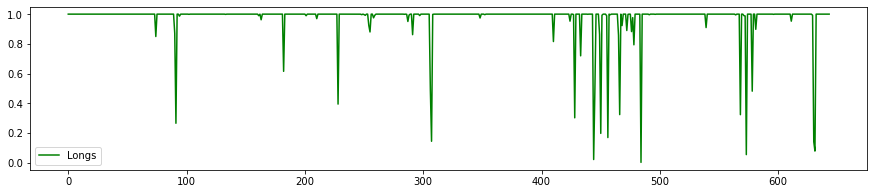

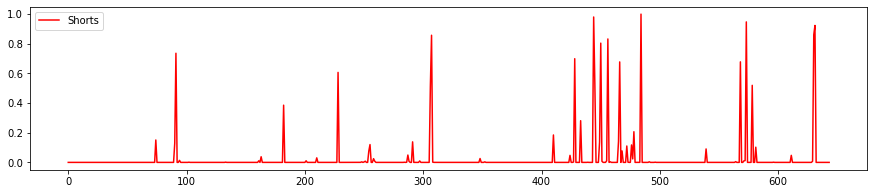

In [18]:
plt.rcParams["figure.figsize"] = (15,3)
df_res[["Longs"]].plot(color="green")
df_res[["Shorts"]].plot(color="red")

<AxesSubplot:>

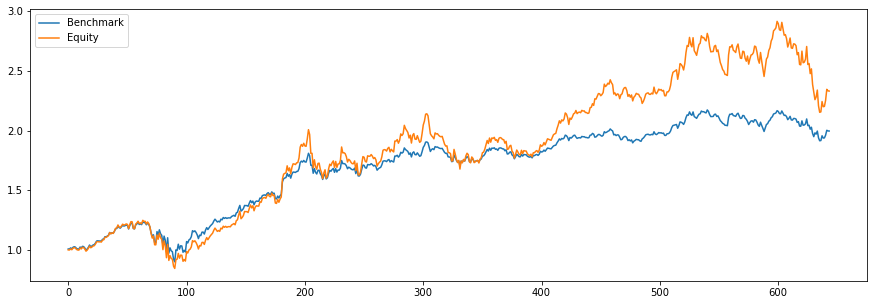

In [19]:
plt.rcParams["figure.figsize"] = (15,5)
df_res[["Benchmark", "Equity"]].plot()

In [20]:
# Metrics
Benchmark_Perc = (df_res["Close_Price"].iloc[-1] / df_res["Close_Price"].iloc[0] - 1) * 100
ROI_Perc = (df_res["Equity"].iloc[-1] / capital - 1) * 100
print(f"Benchmark Return {round(Benchmark_Perc, 2)}%")
print(f"ROI at {round(ROI_Perc, 2)}%")

Benchmark Return 126.86%
ROI at 133.03%


### Resources

PPO Code adapted from https://www.youtube.com/watch?v=hlv79rcHws0 (Machine Learning with Phil)